In [69]:
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import VGG19


In [45]:
df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [46]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [47]:
emotion_label = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

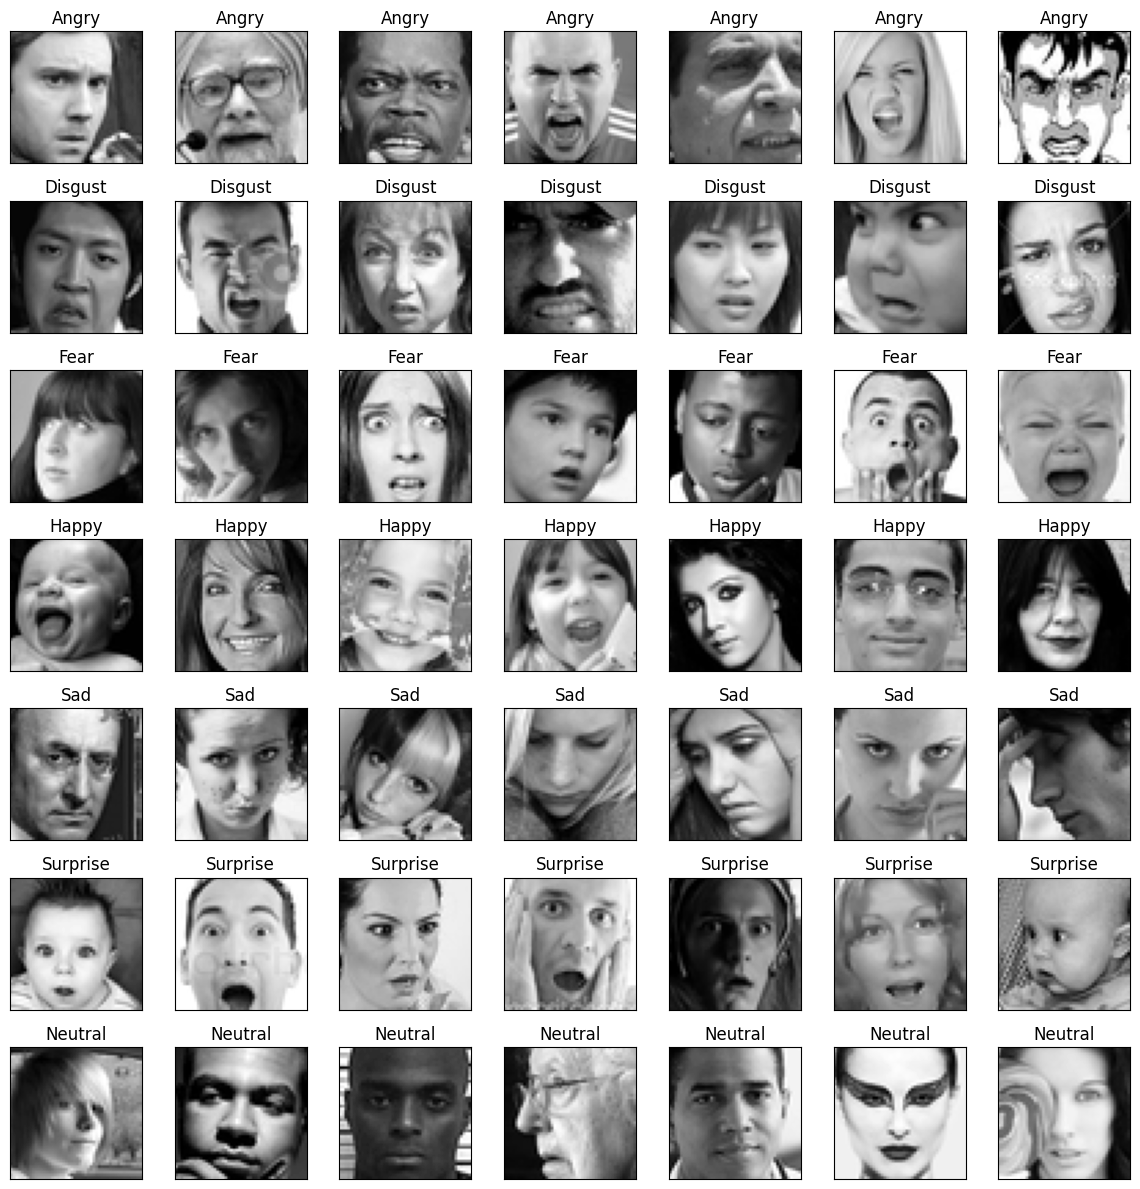

In [20]:
fig = plt.figure(1, (12,12))
k=0

for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48,48).astype('float32')

        k += 1
        ax = plt.subplot(7,7,k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label[label])
        plt.tight_layout()

In [48]:
train = df[df.loc[:,"Usage"] == "Training"].loc[:,:]
valid = df[df.loc[:,"Usage"] == "PublicTest"]
valid.index = range(0,valid.index.size)
test = df[df.loc[:,"Usage"] == "PrivateTest"]
test.index = range(0,test.index.size)

In [49]:
train.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [50]:
#df['pixels'] = [np.fromstring(x, dtype=int, sep=' ').reshape(-1,48,48,1) for x in df['pixels']]
#img_array = np.concatenate(df.pixels)
#le = LabelEncoder()
#img_labels = le.fit_transform(df.emotion)
#img_labels = to_categorical(img_labels)

#X_temp, X_test, y_temp, y_test = train_test_split(img_array, img_labels, test_size=0.2, random_state=1)

#print(X_temp.shape, X_test.shape, y_temp.shape, y_test.shape)

train['pixels'] = [np.fromstring(x, dtype=float, sep=' ').reshape(-1, 48, 48, 1) for x in train['pixels']]
img_array = np.concatenate(train.pixels)

le = LabelEncoder()
img_labels = le.fit_transform(train.emotion)
img_labels = to_categorical(img_labels)

X_train, y_train = img_array, img_labels

print(X_train.shape, y_train.shape)


(28709, 48, 48, 1) (28709, 7)


In [51]:
valid['pixels'] = [np.fromstring(x, dtype=float, sep=' ').reshape(-1, 48, 48, 1) for x in valid['pixels']]
img_array = np.concatenate(valid.pixels)

le = LabelEncoder()
img_labels = le.fit_transform(valid.emotion)
img_labels = to_categorical(img_labels)

X_valid, y_valid = img_array, img_labels

print(X_valid.shape, y_valid.shape)

(3589, 48, 48, 1) (3589, 7)


/tmp/ipykernel_42/3052098697.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['pixels'] = [np.fromstring(x, dtype=float, sep=' ').reshape(-1, 48, 48, 1) for x in valid['pixels']]


In [52]:
test['pixels'] = [np.fromstring(x, dtype=float, sep=' ').reshape(-1, 48, 48, 1) for x in test['pixels']]
img_array = np.concatenate(valid.pixels)

le = LabelEncoder()
img_labels = le.fit_transform(valid.emotion)
img_labels = to_categorical(img_labels)

X_test, y_test = img_array, img_labels

print(X_test.shape, y_test.shape)

(3589, 48, 48, 1) (3589, 7)


/tmp/ipykernel_42/3540529494.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['pixels'] = [np.fromstring(x, dtype=float, sep=' ').reshape(-1, 48, 48, 1) for x in test['pixels']]


In [56]:
X_train_uint8 = X_train.astype(np.uint8)
X_valid_uint8 = X_valid.astype(np.uint8)
X_test_uint8  = X_test.astype(np.uint8)

X_train = np.array([cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) for x in X_train_uint8])
X_valid = np.array([cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) for x in X_valid_uint8])
X_test  = np.array([cv2.cvtColor(x, cv2.COLOR_GRAY2RGB) for x in X_test_uint8])

In [57]:
train_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    brightness_range=(0.8, 1.2),
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,)
train_datagen.fit(X_train)
print("x_train shape",X_train.shape)
print("x_valid shape",X_valid.shape)
print("x_test shape",X_test.shape)

x_train shape (28709, 48, 48, 3)
x_valid shape (3589, 48, 48, 3)
x_test shape (3589, 48, 48, 3)


In [58]:
X_train=X_train.astype('float32')
X_train/=255
X_valid=X_valid.astype('float32')
X_valid/=255
X_test=X_test.astype('float32')
X_test/=255

# **VGG16**

In [59]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
for layer in vgg16.layers:
    layer.trainable = False

In [60]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [61]:
x = vgg16.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
x = Dense(1000, activation='relu')(x)
output_layer = Dense(7, activation='softmax')(x)
vgg16_model = Model(inputs=vgg16.input, outputs=output_layer)

In [62]:
vgg16.trainable = True
opt = tf.keras.optimizers.Adam(0.0001)
vgg16_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [63]:
%%time

h1 = vgg16_model.fit(
    X_train,y_train,
    steps_per_epoch=len(X_train) / 64,
    epochs=50,
    validation_data=(X_valid,y_valid),
    validation_steps=len(X_valid) / 64,
    verbose=1
)

Epoch 1/50
448/448 [==============================] - 35s 65ms/step - loss: 1.4176 - accuracy: 0.4472 - val_loss: 1.2103 - val_accuracy: 0.5288
Epoch 2/50
448/448 [==============================] - 29s 65ms/step - loss: 1.1243 - accuracy: 0.5760 - val_loss: 1.0972 - val_accuracy: 0.5871
Epoch 3/50
448/448 [==============================] - 29s 65ms/step - loss: 0.9902 - accuracy: 0.6329 - val_loss: 1.1356 - val_accuracy: 0.5949
Epoch 4/50
448/448 [==============================] - 29s 64ms/step - loss: 0.8605 - accuracy: 0.6807 - val_loss: 1.0445 - val_accuracy: 0.6155
Epoch 5/50
448/448 [==============================] - 29s 65ms/step - loss: 0.7263 - accuracy: 0.7345 - val_loss: 1.1192 - val_accuracy: 0.6300
Epoch 6/50
448/448 [==============================] - 29s 65ms/step - loss: 0.5760 - accuracy: 0.7971 - val_loss: 1.0897 - val_accuracy: 0.6364
Epoch 7/50
448/448 [==============================] - 29s 65ms/step - loss: 0.4361 - accuracy: 0.8483 - val_loss: 1.1973 - val_accuracy:

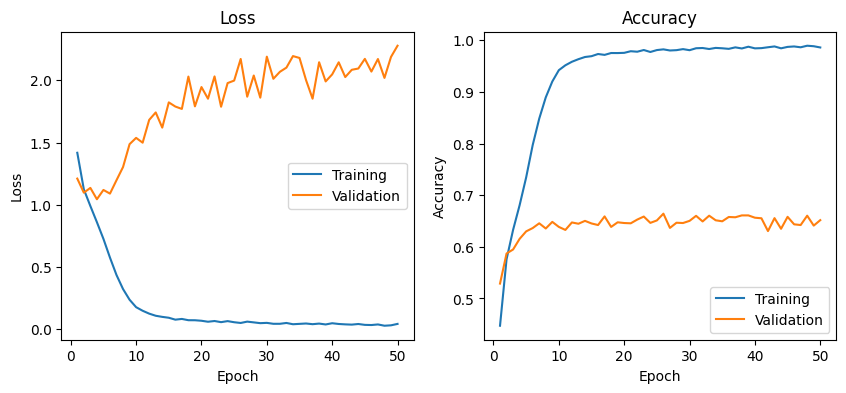

In [64]:
history = h1.history
n_epochs = len(history['loss'])

plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

In [66]:
loss, accuracy = vgg16_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

113/113 [==============================] - 2s 12ms/step - loss: 2.2771 - accuracy: 0.6517
Test Loss: 2.2771
Test Accuracy: 65.17%


# **VGG19**

In [71]:
vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

80134624/80134624 [==============================] - 0s 0us/step


In [72]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

In [74]:
x = vgg19.output
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dense(4096, activation='relu')(x)
x = Dense(1000, activation='relu')(x)
output_layer = Dense(7, activation='softmax')(x)
vgg19_model = Model(inputs=vgg19.input, outputs=output_layer)

In [75]:
opt = tf.keras.optimizers.Adam(0.0001)
vgg19_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [76]:
%%time

h2 = vgg19_model.fit(
    X_train,y_train,
    steps_per_epoch=len(X_train) / 64,
    epochs=50,
    validation_data=(X_valid,y_valid),
    validation_steps=len(X_valid) / 64,
    verbose=1
)

Epoch 1/50
448/448 [==============================] - 42s 79ms/step - loss: 1.5582 - accuracy: 0.3729 - val_loss: 1.3591 - val_accuracy: 0.4765
Epoch 2/50
448/448 [==============================] - 36s 80ms/step - loss: 1.2460 - accuracy: 0.5161 - val_loss: 1.2172 - val_accuracy: 0.5313
Epoch 3/50
448/448 [==============================] - 36s 79ms/step - loss: 1.1258 - accuracy: 0.5739 - val_loss: 1.1360 - val_accuracy: 0.5737
Epoch 4/50
448/448 [==============================] - 36s 80ms/step - loss: 1.0300 - accuracy: 0.6149 - val_loss: 1.0900 - val_accuracy: 0.5968
Epoch 5/50
448/448 [==============================] - 36s 80ms/step - loss: 0.9424 - accuracy: 0.6522 - val_loss: 1.1623 - val_accuracy: 0.5840
Epoch 6/50
448/448 [==============================] - 36s 79ms/step - loss: 0.8430 - accuracy: 0.6925 - val_loss: 1.0506 - val_accuracy: 0.6155
Epoch 7/50
448/448 [==============================] - 36s 80ms/step - loss: 0.7472 - accuracy: 0.7279 - val_loss: 1.1212 - val_accuracy:

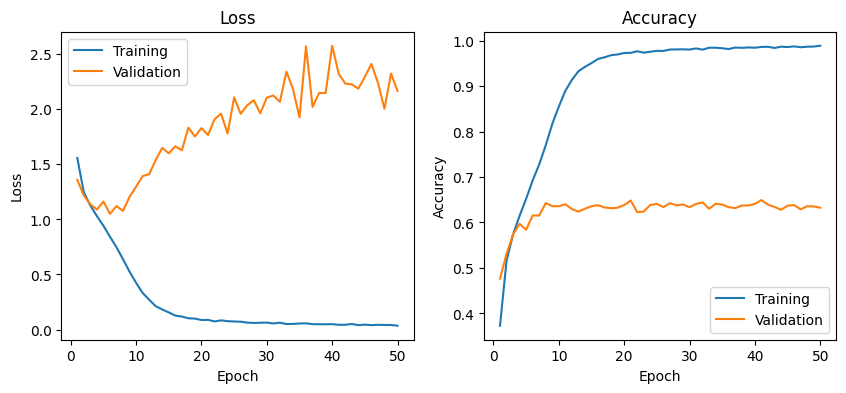

In [77]:
history = h2.history
n_epochs = len(history['loss'])

plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), history['loss'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), history['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), history['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.show()

In [79]:
loss, accuracy = vgg19_model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy * 100:.2f}%')

113/113 [==============================] - 2s 15ms/step - loss: 2.1673 - accuracy: 0.6325
Test Loss: 2.1673
Test Accuracy: 63.25%
